# Assignment for Week 7 - Performance Evaluations: ROC and PR Curves

> Bank Marketing data:  https://archive.ics.uci.edu/ml/datasets/bank+marketing

> The data is related with direct marketing campaigns of a Portuguese banking
> institution. The marketing campaigns were based on phone calls. Often, more
> than one contact to the same client was required, in order to access if the
> product (bank term deposit) would be ('yes') or not ('no') subscribed. 
>
> From the given data set, complete the following:
>   * Try 3 different types of models to make classification predictions on the
      bank marketing dataset 
>   * Calculate the AUC score as a comparison, and at least 2 other metrics
>     (ie: accuracy, F1 score, precision, recall, etc) 
>     - Compare the models’ performance on the same train/test splits 
>  * Plot the ROC curve from the best model, choose what you think the best
>    threshold value is for making predictions


---

# 1 Setup

## 1.A Sanity Check of Provided Data File

Prior to importing any data, we perform a few checks against the file:
* What is the approximate size of the file (will our current configuration
  support the given quantity of data)?
* What is the content of the file and does it use the correct line endings?
* How many rows (lines) are in the file (can be used to double-check that
  the full dataset is loaded by Pandas)?
* Does the data have a header row?


In [1]:
%%bash
declare -a DATA_FILES=("data/bank-full.csv")

for FILE in "${DATA_FILES[@]}"; do
    if [ -f "${FILE}" ] ; then
        echo "${FILE}:"
        echo "    Data file size:      $(du -h ${FILE} | awk '{print $1;}')"
        echo "    Data file type:      $(file --brief ${FILE})"
        echo "    Number of lines:     $(wc -l ${FILE} | awk '{print $1;}')"
        echo "    Data header row?     $(head -n 1 ${FILE})"
    else
        echo "${FILE}: NOT FOUND"
    fi
done

data/bank-full.csv:
    Data file size:      4.4M
    Data file type:      ASCII text
    Number of lines:     45212
    Data header row?     "age";"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"


## 1.B Python/Jupyter Setup

We organize the imports at the begining of the notebook, similar to a
"traditional" Python file.  This is a personal preference.

Furthermore, we prefer the Python `logging` module over "raw" print statements
to stdout.

In [2]:
import logging
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

import seaborn as sns
import sklearn.compose
import sklearn.ensemble
import sklearn.linear_model
import sklearn.manifold
import sklearn.metrics
import sklearn.neural_network
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.svm
import sklearn.utils
import xgboost

# Activate the 'inline' backend such that plots are displayed directly
# after the cell containing the plot command
%matplotlib inline

# Display up to 100 rows
pd.options.display.max_rows = 100

# Set up logging ...
logging.basicConfig(format='%(asctime)s - %(levelname)-6s - %(name)10s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

LOGGER = logging.getLogger('MSDS-680')

RANDOM_SEED = 42


/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 1.C Import the Data

**Note**: As discovered in *1.A*, the separator is `";"`

In [3]:
bank_df = pd.read_csv('data/bank-full.csv', sep=';', low_memory=False)
LOGGER.info(f'bank_df.shape ==> {bank_df.shape[0]} rows x {bank_df.shape[1]} cols')
bank_df.head()

2022-02-27 19:06:44 - INFO   -   MSDS-680 - bank_df.shape ==> 45211 rows x 17 cols


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# 2 Exploratory Data Analysis

## 2.A Column Conversions

As observed in *1.C*, several columns utilize `yes`/`no` values, which can
easily be converted to `1`/`0`.  The redundant conversions of `1 => 1` and
`0 => 0` are so that this block can be executed any number of times and yield
the same result.

In [4]:
for c in ['default', 'housing', 'loan', 'y']:
    bank_df[c] = bank_df[c].map({'yes': 1, 'no': 0,
                                 1: 1, 0: 0})


In [5]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  int64 
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  int64 
 7   loan       45211 non-null  int64 
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  int64 
dtypes: int64(11), object(6)
memory usage: 5.9+ MB


## 2.B Imbalanced Data

As illustrated below, the provided data is imbalanced.  A given model can simply
guess the majority label every time and achieve a `88.3%` *accuracy* rate.

For this exercise, we leave the data in its imbalanced condition to illustrate
that ROC is less susciptible to data imbalance.

In [6]:
bank_df.y.value_counts(normalize=True)

0    0.883015
1    0.116985
Name: y, dtype: float64

# 3 Performance Evaluations: ROC and PR Curves

## 3.A Train / Test Split


In [7]:
label_col = 'y'
categorical_cols = list(bank_df.select_dtypes(include=['object']).columns)
numerical_cols = [c for c in bank_df.columns if c not in categorical_cols + [label_col]]
feature_cols = numerical_cols + categorical_cols

LOGGER.debug(f'Categorical features: {categorical_cols}')
LOGGER.debug(f'Remaining features: {numerical_cols}')

# X = input, y = labels
X = bank_df[feature_cols].values
y = bank_df[label_col].values

# This will randomly split the data according to the provided ratio (0.2)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)


LOGGER.info(f'X_train.shape ==> {X_train.shape[0]} rows x {X_train.shape[1]} cols')
LOGGER.info(f'X_test.shape  ==> {X_test.shape[0]}  rows x {X_test.shape[1]} cols')

LOGGER.info(f'y_train.shape ==> {y_train.shape[0]} rows')
LOGGER.info(f'y_test.shape  ==> {y_test.shape[0]}  rows')

pipeline = sklearn.pipeline.Pipeline([
    (f'ColumnTransformer', sklearn.compose.ColumnTransformer(transformers=[
        (f'Scaler',  sklearn.preprocessing.MinMaxScaler(),  [feature_cols.index(c) for c in numerical_cols]),
        (f'Encoder', sklearn.preprocessing.OneHotEncoder(), [feature_cols.index(c) for c in categorical_cols])
    ], remainder='passthrough')),
])


# Transformed X_train data
Xt_train = pipeline.fit_transform(X_train)
Xt_test  = pipeline.transform(X_test)


2022-02-27 19:06:45 - DEBUG  -   MSDS-680 - Categorical features: ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
2022-02-27 19:06:45 - DEBUG  -   MSDS-680 - Remaining features: ['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'pdays', 'previous']
2022-02-27 19:06:45 - INFO   -   MSDS-680 - X_train.shape ==> 31647 rows x 16 cols
2022-02-27 19:06:45 - INFO   -   MSDS-680 - X_test.shape  ==> 13564  rows x 16 cols
2022-02-27 19:06:45 - INFO   -   MSDS-680 - y_train.shape ==> 31647 rows
2022-02-27 19:06:45 - INFO   -   MSDS-680 - y_test.shape  ==> 13564  rows


## 3.B Model Selection and Creation

In [8]:
models = [
    sklearn.linear_model.LogisticRegression(random_state=RANDOM_SEED,
                                            max_iter=300),

    sklearn.ensemble.RandomForestClassifier(random_state=RANDOM_SEED),

    sklearn.svm.LinearSVC(random_state=RANDOM_SEED),

    xgboost.XGBClassifier(use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=RANDOM_SEED),

    # This model can take ~20m to converge
    sklearn.neural_network.MLPClassifier(hidden_layer_sizes=[2**n for n in range(10, 6, -1)],
                                         random_state=RANDOM_SEED,
                                         max_iter=300)
]


## 3.C Receiver Operating Characteristics

1. Below, we plot the Receiver Operating Characteristics (ROC) curves for the
   models selected above.  Two ROC display methods are used, 
   `RocCurveDisplay.from_predictions` and `RocCurveDisplay.from_estimator`:

  * `RocCurveDisplay.from_predictions` utilizes pre-calculated predictions.
    Since this is a binary classification problem, each prediction will be the
    inferred label for the test data.  In other words, the label is assigned
    according to the default threshold (e.g., `0.5`).  *This yields a ROC curve
    with a single inflection point based on the single recall value for the
    model*
  * `RocCurveDisplay.from_estimator` utilizes the given model's `predict_proba`
    method (if available) to determine the probability of each class for each
    data point.  *This yields a ROC curve with values plotted for a variety of
    thresholds **and illustrates the role that the threshold plays in
    optimizing precision and recall***

2. Similarly, two analgous PR display methods are used

3. Additionally: accuracy, precision, recall, and F1 metrics are calculated for
   each model


2022-02-27 19:06:45 - INFO   -   MSDS-680 - LogisticRegression model
2022-02-27 19:06:47 - INFO   -   MSDS-680 -     Accuracy.... 89.95%
2022-02-27 19:06:47 - INFO   -   MSDS-680 -     Precision... 64.56%
2022-02-27 19:06:47 - INFO   -   MSDS-680 -     Recall...... 32.60%
2022-02-27 19:06:47 - INFO   -   MSDS-680 -     F1 Score.... 43.33%
2022-02-27 19:06:47 - INFO   -   MSDS-680 - RandomForestClassifier model
2022-02-27 19:06:51 - INFO   -   MSDS-680 -     Accuracy.... 90.50%
2022-02-27 19:06:51 - INFO   -   MSDS-680 -     Precision... 66.56%
2022-02-27 19:06:51 - INFO   -   MSDS-680 -     Recall...... 38.86%
2022-02-27 19:06:51 - INFO   -   MSDS-680 -     F1 Score.... 49.07%
2022-02-27 19:06:52 - INFO   -   MSDS-680 - LinearSVC model
2022-02-27 19:06:53 - INFO   -   MSDS-680 -     Accuracy.... 89.94%
2022-02-27 19:06:53 - INFO   -   MSDS-680 -     Precision... 65.81%
2022-02-27 19:06:53 - INFO   -   MSDS-680 -     Recall...... 30.35%
2022-02-27 19:06:53 - INFO   -   MSDS-680 -     F1

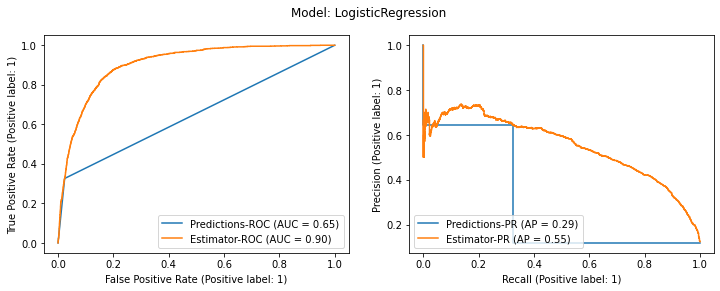

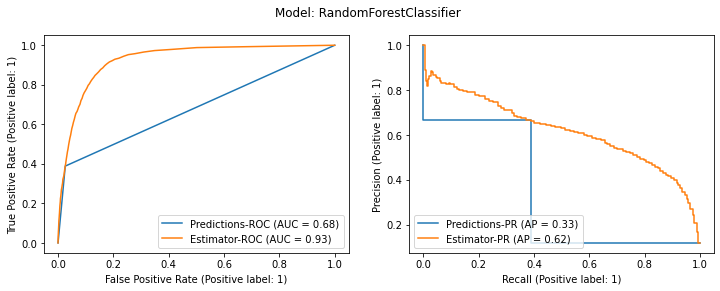

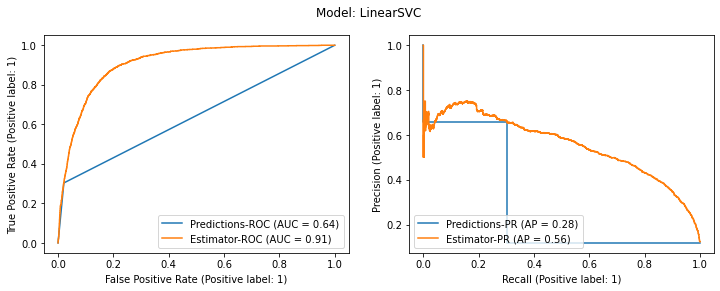

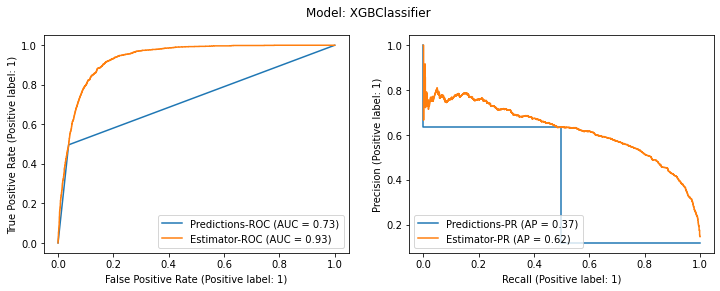

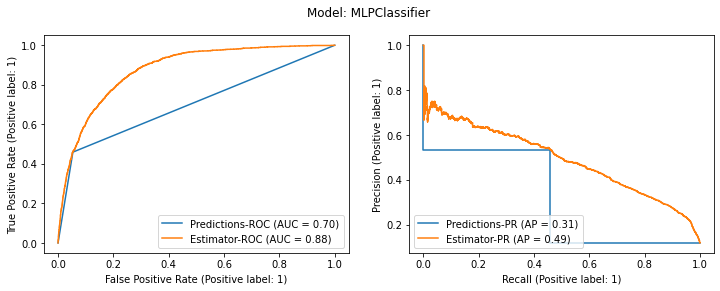

In [9]:
for m in models:
    LOGGER.info(f'{m.__class__.__name__} model')
    m.fit(Xt_train, y_train)

    y_pred = m.predict(Xt_test)

    # Print performance metrics
    accuracy    = sklearn.metrics.accuracy_score(y_test, y_pred)
    precision   = sklearn.metrics.precision_score(y_test, y_pred)
    recall      = sklearn.metrics.recall_score(y_test, y_pred)
    f1          = sklearn.metrics.f1_score(y_test, y_pred)

    LOGGER.info(f'    {"Accuracy":.<12s} {accuracy:.2%}')
    LOGGER.info(f'    {"Precision":.<12s} {precision:.2%}')
    LOGGER.info(f'    {"Recall":.<12s} {recall:.2%}')
    LOGGER.info(f'    {"F1 Score":.<12s} {f1:.2%}')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'Model: {m.__class__.__name__}')

    _ = sklearn.metrics.RocCurveDisplay.from_predictions(y_test,
                                                         y_pred,
                                                         name=f'Predictions-ROC',
                                                         ax=ax1)

    _ = sklearn.metrics.RocCurveDisplay.from_estimator(m,
                                                       Xt_test,
                                                       y_test,
                                                       name=f'Estimator-ROC',
                                                       ax=ax1)

    _ = sklearn.metrics.PrecisionRecallDisplay.from_predictions(y_test,
                                                                y_pred,
                                                                name=f'Predictions-PR',
                                                                ax=ax2)

    _ = sklearn.metrics.PrecisionRecallDisplay.from_estimator(m,
                                                              Xt_test,
                                                              y_test,
                                                              name=f'Estimator-PR',
                                                              ax=ax2)


# 4 Summary

Using the default threshold
* `XGBClassifier` achieved the highest accuracy (`90.7%`), recall (`49.6%`),
  and F1 (`55.7%`) scores
* `RandomForestClassifier` achieved the highest precision (`66.6%`)
* `XGBClassifier` achieved the highest ROC AUC (`0.73`)

With thresholds adjusted automatically by the `RocCurveDisplay.from_estimator`,
`XGBClassifier` and `RandomForestClassifier` both achieved a ROC AUC of `0.93`